In [82]:
import pandas as pd
import numpy as np

import math
import re

from matplotlib import colors, rcParams
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium

from shapely.geometry import polygon, multipolygon, Point
from shapely.ops import cascaded_union

import mapclassify as mc
import libpysal as lp

from esda import moran # Morans
from splot.esda import plot_moran, moran_scatterplot

from scipy.stats import shapiro, boxcox

from statsmodels.stats.multitest import multipletests

import contextily as ctx

In [481]:
# rcParams['figure.dpi']=300

## Load District boundaries

In [4]:
districts_pop_gdf = gpd.read_file('data/Bangkok-saturated-districts.shp')

districts_pop_gdf = districts_pop_gdf[['district','venue_va_1','geometry']]
districts_pop_gdf.columns = ['district','venue_val_per_capita','geometry']
districts_pop_gdf

,district,venue_val_per_capita,geometry
0,Ban Na,0.001687,"POLYGON ((101.06481 14.41179, 101.06536 14.410..."
1,Ban Pho,0.002365,"POLYGON ((100.96163 13.70401, 100.96242 13.703..."
2,Bang Bo,0.001102,"POLYGON ((100.93635 13.66819, 100.93792 13.667..."
3,Bang Bon,0.000474,"POLYGON ((100.43022 13.67181, 100.42820 13.669..."
4,Bang Bua Thong,0.001762,"POLYGON ((100.38375 13.98669, 100.38609 13.986..."
...,...,...,...
78,Wang Noi,0.001517,"POLYGON ((100.82285 14.32829, 100.82439 14.326..."
79,Wang Thonglang,0.001202,"POLYGON ((100.58796 13.80530, 100.58826 13.805..."
80,Wattana,0.005168,"POLYGON ((100.55692 13.75175, 100.55806 13.751..."
81,Wihan Daeng,0.000716,"POLYGON ((100.99131 14.42083, 100.99177 14.418..."


### Transform Venue Value per Capita so it is normally distributed

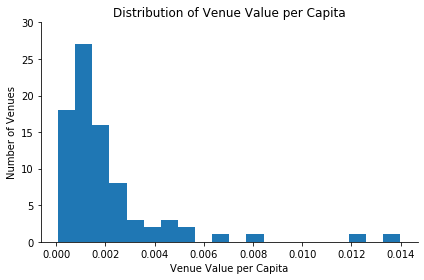

In [5]:
# Plot Venue Value per Capita distribution
ax = districts_pop_gdf.venue_val_per_capita.hist(bins=20, figsize=(6,4))
plt.title('Distribution of Venue Value per Capita')
plt.ylim(0,30)
plt.xlabel('Venue Value per Capita')
plt.ylabel('Number of Venues')
sns.despine(ax=ax,top=True,right=True)
ax.grid(False)
plt.tight_layout()
plt.show()

In [6]:
# If Shapiro-Wilkes test returns value less than 0.05, data is skewed
shapiro(districts_pop_gdf.venue_val_per_capita)[1]

6.094347032234437e-13

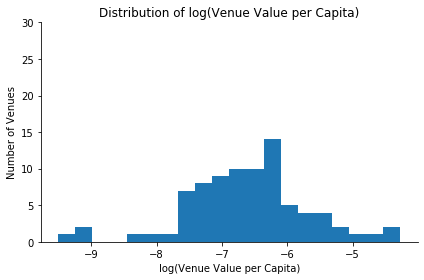

In [7]:
# Plot log-transformed Venue Value per Capita
ax = districts_pop_gdf.venue_val_per_capita.apply(np.log).hist(bins=20, figsize=(6,4))
plt.ylim(0,30)
plt.title('Distribution of log(Venue Value per Capita)')
plt.xlabel('log(Venue Value per Capita)')
plt.ylabel('Number of Venues')
sns.despine(ax=ax,top=True,right=True)
ax.grid(False)
plt.tight_layout()
plt.show()

In [18]:
# If Shapiro-Wilkes test returns value less than 0.05, data is skewed
shapiro(districts_pop_gdf.venue_val_per_capita.apply(np.log))[1]

0.046096764504909515

In [8]:
boxcox_venue_val_per_capita = boxcox(districts_pop_gdf.venue_val_per_capita)
boxcox_venue_val_per_capita[0]

array([-4.79018019, -4.60279191, -5.01810607, -5.44311761, -4.76641776,
       -4.70522401, -5.00357753, -4.72345506, -4.9020112 , -4.64522691,
       -4.98695987, -4.67874634, -5.42201111, -4.63373222, -4.65594654,
       -4.72754063, -4.62123616, -3.51114714, -5.06991013, -5.09037741,
       -4.86978395, -5.08100404, -4.71341069, -6.26498919, -5.10288935,
       -4.33788716, -5.41826287, -5.26606243, -4.81977805, -5.54215979,
       -5.1963228 , -4.78189536, -5.10040659, -5.23719383, -4.41394849,
       -4.00720885, -5.76877826, -4.7023986 , -4.77244867, -5.11835866,
       -5.14560759, -4.97585814, -4.17700084, -5.11349049, -4.54174157,
       -4.70119416, -4.66130425, -5.32665524, -5.02268338, -4.82328228,
       -5.67603825, -6.09219605, -4.61683668, -4.94938405, -3.58388259,
       -5.27675438, -4.19853587, -4.22865849, -5.41338058, -5.20247076,
       -4.29622358, -5.06882767, -4.92201396, -4.98420607, -5.19394546,
       -6.12759677, -5.23605607, -5.00495774, -4.87745911, -5.41

In [9]:
# Print lambda computed by Box Cox
boxcox_venue_val_per_capita[1]

0.09478097106621712

In [10]:
districts_pop_gdf['boxcox_venue_val_per_capita'] = boxcox_venue_val_per_capita[0]

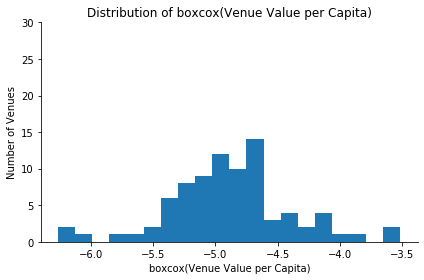

In [11]:
# Plot Box Cox transformed Venue Value per Capita
ax = districts_pop_gdf.boxcox_venue_val_per_capita.hist(bins=20, figsize=(6,4))
plt.ylim(0,30)
plt.title('Distribution of boxcox(Venue Value per Capita)')
plt.xlabel('boxcox(Venue Value per Capita)')
plt.ylabel('Number of Venues')
sns.despine(ax=ax,top=True,right=True)
ax.grid(False)
plt.tight_layout()
plt.show()

In [12]:
shapiro(districts_pop_gdf['boxcox_venue_val_per_capita'])[1]

0.13462574779987335

In [24]:
# Convert districts_pop_gdf to Mercator projection for plotting with basemaps
districts_pop_gdf.to_crs(epsg=3857,inplace=True)

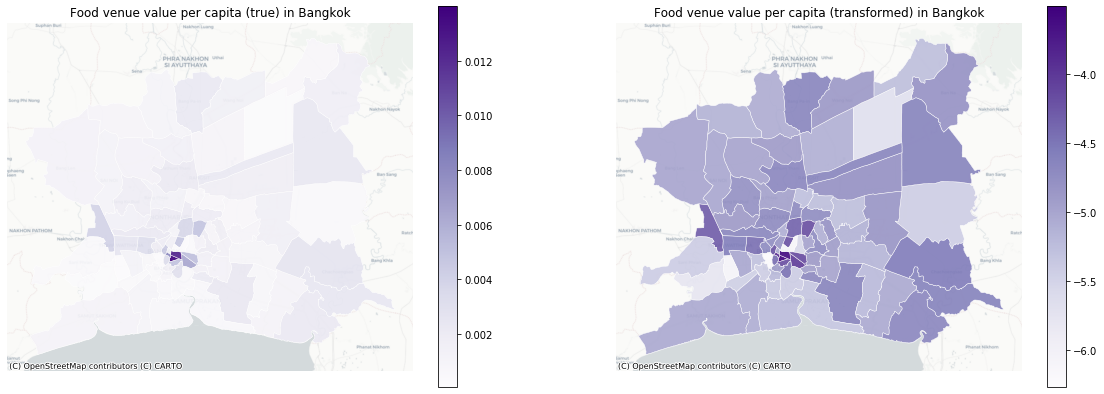

In [26]:
# Plot true and transformed data to visualize comparison in distributions
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(20, 7))

districts_pop_gdf.plot(column='venue_val_per_capita', \
        cmap='Purples', linewidth=0.5, ax=ax1, \
        edgecolor='white', legend=True, alpha=0.9)

districts_pop_gdf.plot(column='boxcox_venue_val_per_capita', \
        cmap='Purples', linewidth=0.5, ax=ax2, \
        edgecolor='white', legend=True, alpha=0.9)

ax1.set_axis_off()
ax2.set_axis_off()

ctx.add_basemap(ax1, url=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2, url=ctx.providers.CartoDB.Positron)

ax1.set_title('Food venue value per capita (true) in Bangkok')
ax2.set_title('Food venue value per capita (transformed) in Bangkok')
plt.show()

## Venue Value per Capita per District - Global Morans

Global autocorrelation test - is the distribution of food venues random?

In [13]:
# Generate weights matrix with Queen first-order contiguity

wq = lp.weights.Queen.from_dataframe(districts_pop_gdf, idVariable='district')
wq.transform = 'r'

In [14]:
# Confirm no islands
wq.islands

[]

In [15]:
# Inspect connectivity of districts
neigh_list = [len(d) for d in wq.neighbors.values()]

print('Queens weight median neighbors: ', np.median(neigh_list))
print('Queens weight average neighbors: ', round(np.average(neigh_list), 2))
print('Queens weight max neighbors: ', np.max(neigh_list))
print('Queens weight min neighbors: ', np.min(neigh_list))

Queens weight median neighbors:  6.0
Queens weight average neighbors:  5.54
Queens weight max neighbors:  10
Queens weight min neighbors:  2


In [16]:
# Compute spatial lag - the weighted average of food venue value per capita per district
# The spatial leg standardizes the rows and takes the average value of all venues in each district.

y = districts_pop_gdf['boxcox_venue_val_per_capita']
ylag = lp.weights.lag_spatial(wq, y)
ylag[0:5]

array([-5.17752811, -4.73859806, -4.87004311, -5.38046522, -4.90023561])

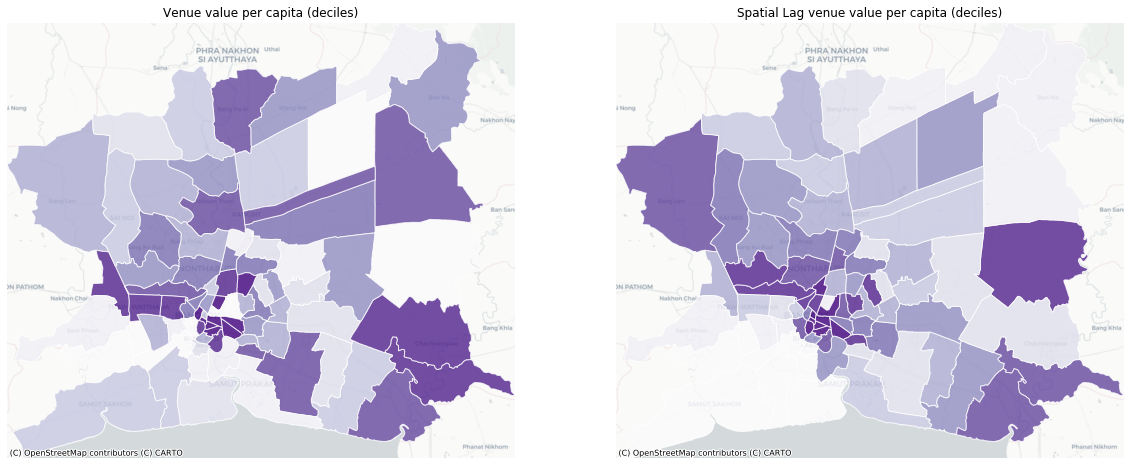

In [25]:
# Plot Venue Value per Capita vs its Spatial Lag
districts_pop_gdf['lag_boxcox_venue_val_per_capita'] = ylag
f,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

districts_pop_gdf.plot(column='venue_val_per_capita', ax=ax1, edgecolor='white',
        scheme="quantiles",  k=10, cmap='Purples', alpha=0.8)
ax1.axis(districts_pop_gdf.total_bounds[np.asarray([0,2,1,3])])
ax1.set_title("Venue value per capita (deciles)")
ctx.add_basemap(ax1, url=ctx.providers.CartoDB.Positron)

districts_pop_gdf.plot(column='lag_boxcox_venue_val_per_capita', ax=ax2, edgecolor='white',
        scheme='quantiles', cmap='Purples', k=10,alpha=0.8)
ax2.axis(districts_pop_gdf.total_bounds[np.asarray([0,2,1,3])])
ax2.set_title("Spatial Lag venue value per capita (deciles)")
ctx.add_basemap(ax2, url=ctx.providers.CartoDB.Positron)

ax1.axis('off')
ax2.axis('off')

plt.show()

In [27]:
np.random.seed(123)
mi = moran.Moran(y, wq, permutations=9999, two_tailed=False)

Text(0.5, 1.0, "Global Moran's I (permutations=9999, $p$ = 0.0004)")

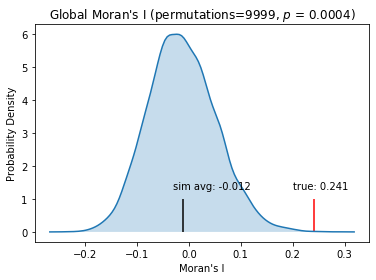

In [30]:
ax = sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")
plt.ylabel('Probability Density')
ax.annotate('sim avg: {}'.format(round(mi.EI,3)), (-0.03,1.3))
ax.annotate('true: {}'.format(round(mi.I,3)), (0.2,1.3))
# plt.title("Global Moran's I (0.241) vs. permuted expected value (-0.012)")
plt.title("Global Moran\'s I (permutations=9999, $p$ = 0.0004)")

In [31]:
# A p-value of 0.05 and less is significant
mi.p_sim

0.0004

In [32]:
# Globally, distribution is statistically significant. 
# We reject our null hypothesis that venue distribution is random.
# Instead, we have significant clustering of 'like' values

## Local Autocorrelation

In [33]:
# since .05/N is on the order of 1e − 4,
# we need at least 10,000 to establish whether a simulation is anomalous
li = moran.Moran_Local(y, wq, permutations=9999)

# Determine number of statistically-significant clusters/outliers with traditional alpha
print('Num clusters/outliers: ', (li.p_sim < 0.05).sum())

Num clusters/outliers:  17


In [34]:
# Determine number of statistically-significant clusters/outliers with Bonferroni correction
print('Num clusters/outliers: ', (li.p_sim < 0.0006).sum())

Num clusters/outliers:  3


In [43]:
# Apply Benjamini/Hochberg False Discovery Rate to p-values, 
# a less conservative correction than Bonferroni approach
fdr_corrected_pval = multipletests(li.p_sim, method='fdr_bh')

# Record measures of local spatial association and corrected p-value
districts_pop_gdf.loc[:,'I_i'] = li.Is
districts_pop_gdf.loc[:,'p_r'] = li.p_sim
districts_pop_gdf.loc[:,'p_n'] = li.p_z_sim
districts_pop_gdf.loc[:,'p_fdr'] = fdr_corrected_pval[1]
districts_pop_gdf.loc[:,'z_score'] = li.z_sim
districts_pop_gdf.loc[:,'quadrant'] = li.q

districts_pop_gdf.head()

,district,venue_val_per_capita,geometry,boxcox_venue_val_per_capita,lag_boxcox_venue_val_per_capita,I_i,p_r,p_n,p_fdr,z_score,quadrant
0,Ban Na,0.001687,"POLYGON ((11250483.298 1621502.925, 11250544.5...",-4.790180,-5.177528,-0.115676,0.1446,0.152782,0.424731,-1.024576,4
1,Ban Pho,0.002365,"POLYGON ((11238997.575 1540280.204, 11239084.8...",-4.602792,-4.738598,0.174825,0.2806,0.289612,0.494052,0.554519,1
2,Bang Bo,0.001102,"POLYGON ((11236182.862 1536176.328, 11236357.9...",-5.018106,-4.870043,-0.010043,0.4481,0.455832,0.494052,-0.110941,2
3,Bang Bon,0.000474,"POLYGON ((11179841.285 1536590.709, 11179615.9...",-5.443118,-5.380465,1.101386,0.0036,0.002827,0.042686,2.767246,3
4,Bang Bua Thong,0.001762,"POLYGON ((11174668.045 1572689.571, 11174928.8...",-4.766418,-4.900236,-0.005441,0.4881,0.486865,0.494052,-0.032930,4


In [38]:
# Instead of 0.05 limit, use FDR-corrected upper bound
P_VAL = 0.0048

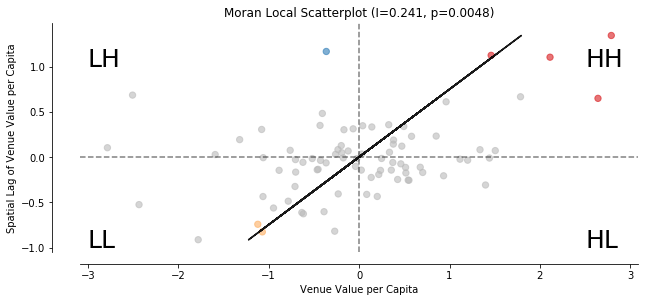

In [39]:
# Plot Moran's Scatterplot
fig, ax = plt.subplots(1, figsize=(10,6))
moran_scatterplot(li, p=P_VAL, ax=ax)
ax.set_title("Moran Local Scatterplot (I={}, p={})".format(str(round(mi.I, 3)), P_VAL))
ax.set_xlabel('Venue Value per Capita')
ax.set_ylabel('Spatial Lag of Venue Value per Capita')
plt.text(2.5, 1, 'HH', fontsize=25)
plt.text(2.5, -1, 'HL', fontsize=25)
plt.text(-3, 1, 'LH', fontsize=25)
plt.text(-3, -1, 'LL', fontsize=25)
plt.show()

In [50]:
# Define labeler with p-value limits
def get_labels(quad_list, signif_list, p_max=P_VAL, p_min=0.0, mark_insignif=True):
    
    labels = []
    spot_labels = ['0 not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
    
    for i,s in enumerate(signif_list):
        if (s<p_max and s>=p_min):
            labels.append(spot_labels[quad_list[i]])
        elif (mark_insignif):
            labels.append(spot_labels[0])
        else:
            labels.append(np.nan)
    return labels

In [54]:
districts_pop_gdf.loc[:,'cluster_category'] = get_labels(li.q, li.p_sim)
districts_pop_gdf.loc[:,'secondary_cluster_category'] = get_labels(li.q, li.p_sim, p_max=0.05, p_min=P_VAL, mark_insignif=False)
districts_pop_gdf.loc[:,'cluster_category'] = districts_pop_gdf['cluster_category'].astype('category')
districts_pop_gdf.loc[:,'secondary_cluster_category'] = districts_pop_gdf['secondary_cluster_category'].astype('category')
districts_pop_gdf.head()

,district,venue_val_per_capita,geometry,boxcox_venue_val_per_capita,lag_boxcox_venue_val_per_capita,I_i,p_r,p_n,p_fdr,z_score,quadrant,cluster_category,secondary_cluster_category
0,Ban Na,0.001687,"POLYGON ((11250483.298 1621502.925, 11250544.5...",-4.790180,-5.177528,-0.115676,0.1446,0.152782,0.424731,-1.024576,4,0 not significant,NaN
1,Ban Pho,0.002365,"POLYGON ((11238997.575 1540280.204, 11239084.8...",-4.602792,-4.738598,0.174825,0.2806,0.289612,0.494052,0.554519,1,0 not significant,NaN
2,Bang Bo,0.001102,"POLYGON ((11236182.862 1536176.328, 11236357.9...",-5.018106,-4.870043,-0.010043,0.4481,0.455832,0.494052,-0.110941,2,0 not significant,NaN
3,Bang Bon,0.000474,"POLYGON ((11179841.285 1536590.709, 11179615.9...",-5.443118,-5.380465,1.101386,0.0036,0.002827,0.042686,2.767246,3,3 cold spot,NaN
4,Bang Bua Thong,0.001762,"POLYGON ((11174668.045 1572689.571, 11174928.8...",-4.766418,-4.900236,-0.005441,0.4881,0.486865,0.494052,-0.032930,4,0 not significant,NaN


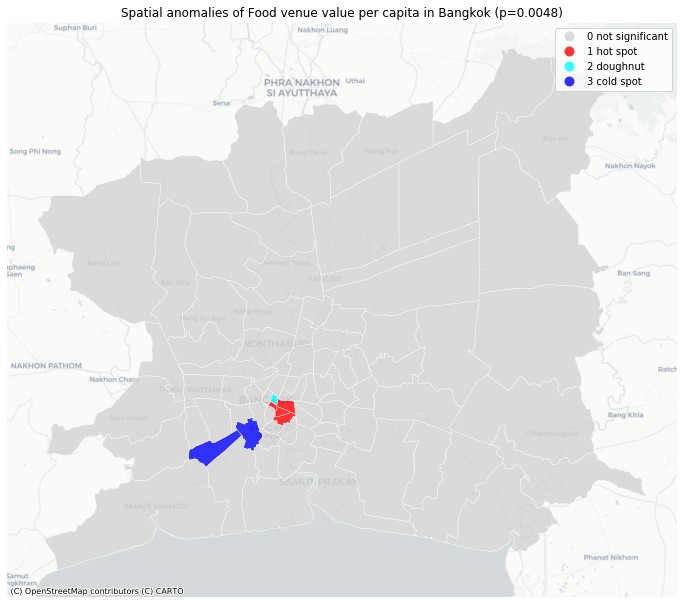

In [55]:
# Plot clusters/outliers identified as significant
f, ax = plt.subplots(1, figsize=(12, 12))

districts_pop_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=colors.ListedColormap(['lightgrey', 'red', 'cyan', 'blue']), linewidth=0.5, ax=ax, \
        edgecolor='white', legend=True, alpha=0.8)

ax.set_axis_off()
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Positron)

plt.title('Spatial anomalies of Food venue value per capita in Bangkok (p=0.0048)')
plt.show()

## Sensitivity Analysis
The goal of sensistivity analysis is to identify an area of interest. It takes into account neighboring regions since, by definition, Moran's I says something about a significant district's neighbors, too.

In [57]:
# Define helper to generate Significance bins for Sensitivity Analysis
def get_sig_bin(p_r):
    if (p_r > 0.01):
        return 0.05
    if (p_r > P_VAL):
        return 0.01
    if (p_r > 0.001):
        return P_VAL
    if (p_r > 0.0006): # Bonferroni
        return 0.001
    return 0.0006

sig_districts_gdf = districts_pop_gdf[districts_pop_gdf.p_r < 0.05].copy()
sig_districts_gdf.loc[:,'sig_bin'] = sig_districts_gdf.p_r.apply(get_sig_bin)

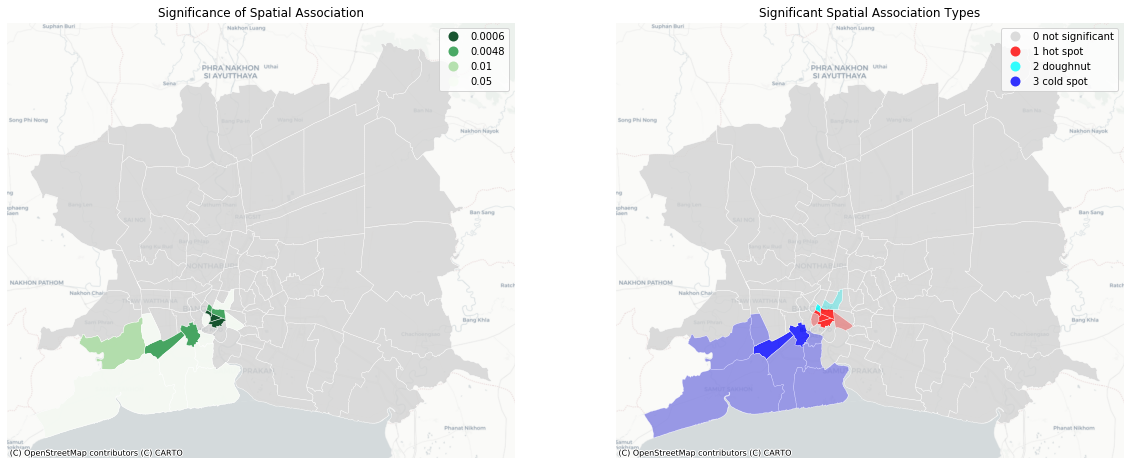

In [58]:
# Plot significance bands alongside cluster/outlier types
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 12))

districts_pop_gdf.plot(ax=ax1, color='lightgrey', alpha=0.8, edgecolor='white', linewidth=0.5, figsize=(10, 7))
sig_districts_gdf.plot(column='sig_bin', ax=ax1, categorical=True,\
        k=5, cmap='Greens_r', linewidth=0.5,\
        edgecolor='white', alpha=0.9, legend=True)
ax1.set_axis_off()
ctx.add_basemap(ax1, url=ctx.providers.CartoDB.Positron)
ax1.set_title('Significance of Spatial Association')

districts_pop_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=colors.ListedColormap(['lightgrey', 'red', 'cyan', 'blue']), linewidth=0.5, ax=ax2, \
        edgecolor='white', legend=True, alpha=0.8)
districts_pop_gdf.dropna().plot(column='secondary_cluster_category', categorical=True, \
        k=2, cmap=colors.ListedColormap(['red', 'cyan', 'blue']), linewidth=0.5, ax=ax2, \
        edgecolor='white', alpha=0.3)

ax2.set_axis_off()
ctx.add_basemap(ax2, url=ctx.providers.CartoDB.Positron)
ax2.set_title('Significant Spatial Association Types')
plt.show()

In [60]:
# Print Doughnut neighbourhoods in order of significance
districts_pop_gdf[districts_pop_gdf.cluster_category=='2 doughnut'][['district','I_i','p_n','p_r','p_fdr','z_score']]\
    .sort_values('p_r')

,district,I_i,p_n,p_r,p_fdr,z_score
61,Pom Pram Sattru,-0.559525,0.000914,0.0012,0.0249,-3.116951


In [63]:
# Print Hot Spot neighbourhoods in order of significance
districts_pop_gdf[districts_pop_gdf.cluster_category=='1 hot spot'][['district','I_i','p_n','p_r','p_fdr','z_score']]\
    .sort_values('p_r')

,district,I_i,p_n,p_r,p_fdr,z_score
17,Bang Rak,4.946173,0.000050,0.0001,0.008300,3.891609
72,Sathorn,2.166134,0.000063,0.0002,0.008300,3.832562
70,Samphantawong,3.075534,0.000212,0.0004,0.011067,3.525030
54,Pathum Wan,2.260119,0.002925,0.0031,0.042686,2.756067


In [64]:
# Print Cold Spot neighbourhoods in order of significance
districts_pop_gdf[districts_pop_gdf.cluster_category=='3 cold spot'][['district','I_i','p_n','p_r','p_fdr','z_score']]\
    .sort_values('p_r')

,district,I_i,p_n,p_r,p_fdr,z_score
26,Chom Thong,1.171248,0.002439,0.0024,0.039840,2.814929
3,Bang Bon,1.101386,0.002827,0.0036,0.042686,2.767246


In [66]:
cores_gdf = districts_pop_gdf[districts_pop_gdf.p_r < P_VAL]
cores = cores_gdf.district.values
cores

array(['Bang Bon', 'Bang Rak', 'Chom Thong', 'Pathum Wan',
       'Pom Pram Sattru', 'Samphantawong', 'Sathorn'], dtype=object)

In [67]:
# Use core cluster/outliers to find neighboring regions
cores_neighbors_polygons = []

for c in cores:
    neigh = wq.neighbors[c]
    neigh.append(c)
    
    cores_neighbors_geom = districts_pop_gdf[districts_pop_gdf.district.isin(neigh)]\
                                .assign(core=c)\
                                .dissolve(by='core')    
    cores_neighbors_polygons.append(cores_neighbors_geom.geometry.values[0])

# Since areas are self-clustered, boundaries can be dissolved into a single area of interest    
area_of_interest = gpd.GeoSeries(cascaded_union(cores_neighbors_polygons))
area_of_interest

0    POLYGON ((11185202.654 1528561.995, 11185148.4...
dtype: geometry

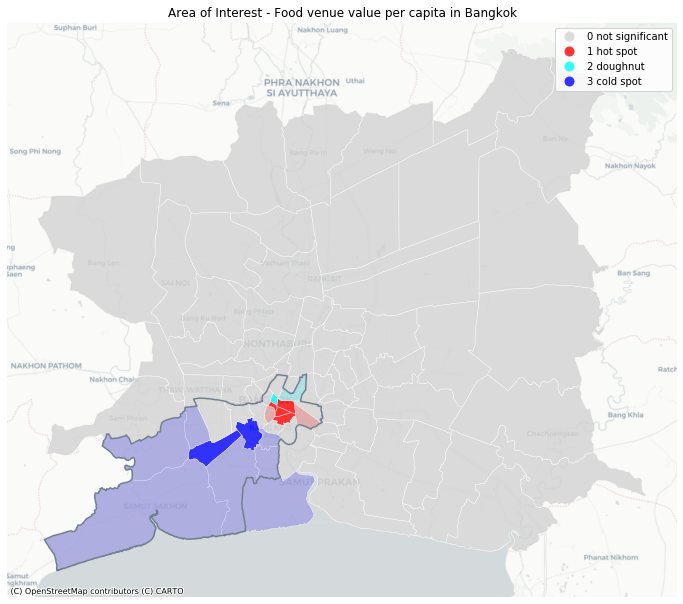

In [130]:
# Plot area of interest
f, ax = plt.subplots(1, figsize=(12, 12))

districts_pop_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=colors.ListedColormap(['lightgrey', 'red', 'cyan', 'blue']), linewidth=0.5, ax=ax, \
        edgecolor='white', legend=True, alpha=0.8)

districts_pop_gdf.dropna().plot(column='secondary_cluster_category', categorical=True, \
        k=2, cmap=colors.ListedColormap(['red', 'cyan', 'blue']), linewidth=0.5, ax=ax, \
        edgecolor='white', alpha=0.2)

area_of_interest.boundary.plot(color='slategrey',ax=ax)

ax.set_axis_off()
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Positron)

plt.title('Area of Interest - Food venue value per capita in Bangkok')
plt.show()

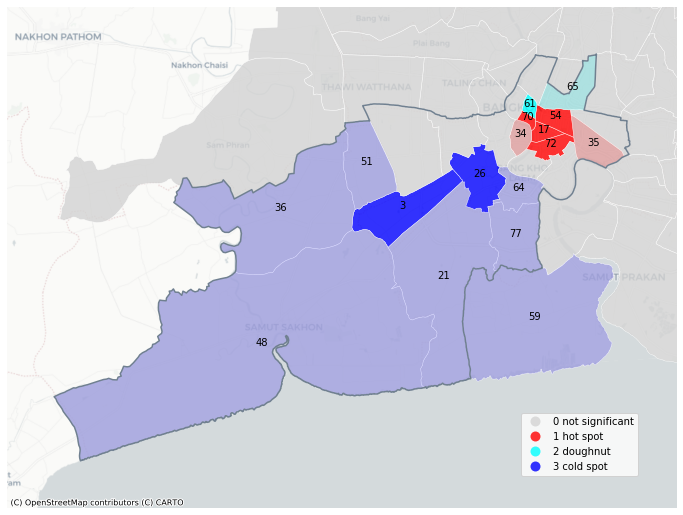

In [129]:
# Plot area of interest
f, ax = plt.subplots(1, figsize=(12, 12))

districts_pop_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=colors.ListedColormap(['lightgrey', 'red', 'cyan', 'blue']), linewidth=0.5, ax=ax, \
        edgecolor='white', legend=True, alpha=0.8)

districts_pop_gdf.dropna().plot(column='secondary_cluster_category', categorical=True, \
        k=2, cmap=colors.ListedColormap(['red', 'cyan', 'blue']), linewidth=0.5, ax=ax, \
        edgecolor='white', alpha=0.2)

area_of_interest.boundary.plot(color='slategrey',ax=ax)

minx, miny, maxx, maxy = area_of_interest.total_bounds
ax.set_xlim(minx-5000, maxx+5000)
ax.set_ylim(miny-5000, maxy+5000)

ax.set_axis_off()
ctx.add_basemap(ax, url=ctx.providers.CartoDB.Positron)

for i,d in sig_districts_gdf.iterrows():
    ax.annotate(i,d.geometry.centroid.coords[0],ha='center')

leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.95, 0.2))
    
plt.title('Area of Interest - Food venue value per capita in Bangkok')
plt.show()

In [514]:
# Save results to file
districts_pop_gdf.reset_index()[['index','district', 'geometry', 'boxcox_venue_val_per_capita',
       'lag_boxcox_venue_val_per_capita','I_i','p_n','p_r','p_fdr','z_score','quadrant']].to_file('data/output-Bangkok-boxcox.shp')

In [96]:
# Generate results table for report
districts_pop_gdf.loc[:,'cluster_type']=get_labels(li.q, li.p_sim, p_max=0.05)
output_stats_df = districts_pop_gdf[['district', 'I_i', 'z_score', 'p_n', 'p_r', 'p_fdr', 'cluster_type']].copy()

output_stats_df.loc[:,'I_i'] = output_stats_df.I_i.apply(lambda x: round(x, 3))
output_stats_df.loc[:,'p_n'] = output_stats_df.p_n.apply(lambda x: round(x, 5))
output_stats_df.loc[:,'p_fdr'] = output_stats_df.p_fdr.apply(lambda x: round(x, 5))
output_stats_df.loc[:,'z_score'] = output_stats_df.z_score.apply(lambda x: round(x, 3))

output_stats_df.to_csv('data/output-Bangkok-stats.csv')
output_stats_df[output_stats_df.p_r<0.05].sort_values('p_r').to_csv('data/output-Bangkok-reccs.csv')